# Описание
В данной работе представлено исследование стоимости квартир (домов) в Тегеране, информацию о которых собрал потенциальный покупатель.

Данные содержат следующую информацию:
- Area – площадь жилья в квадратных метрах;
- Room – количество жилых комнат;
- Parking – наличие паркинга;
- Elevator – наличие лифта;
- Warehouse – наличие складского помещения;
- Address – район города;
- Price – цена в томанах; 
- Price(USD) – цена в долларах США.

**Этапы выполнения проекта**:

- Подготовка и анализ данных;
- Обучение нескольких моделей с подбором гиперпараметров;
- Анализ результатов.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('housePrice.csv')

## Анализ данных

In [3]:
display(df.head())

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [5]:
df[df['Address'].isna() == True].head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
43,60,2,True,True,True,NaN,2.650000e+09,88333.33
662,85,2,True,True,True,NaN,1.955000e+09,65166.67
706,117,2,True,True,True,NaN,6.500000e+09,216666.67
1108,77,2,True,True,False,NaN,2.020000e+09,67333.33
1109,71,1,True,True,True,NaN,2.300000e+09,76666.67


В представленной таблице присутствуют пропуски в столце Address. Также стоит обратить внимание на столбец Area, тип которого вместо числового является строковым. В дальнейшем указанные недочеты будут исправлены.

In [6]:
df['Address'].nunique()

192

In [7]:
df["Area"] = pd.to_numeric(df["Area"], errors='coerce') 

In [8]:
df = df.dropna()

In [9]:
df[["Area",'Room','Price(USD)']].describe()

,Area,Room,Price(USD)
count,3450.000000,3450.000000,3.450000e+03
mean,106.917391,2.081159,1.791854e+05
std,69.550976,0.760216,2.708639e+05
min,30.000000,0.000000,1.200000e+02
25%,69.000000,2.000000,4.730833e+04
50%,90.000000,2.000000,9.666667e+04
75%,120.000000,2.000000,2.000000e+05
max,929.000000,5.000000,3.080000e+06


Из представленного описание можно заметить, что в данных могут присутствовать аномальные значения. Например, жилье с количеством комнат равным 0. Нет уточнения, это квартиры студии или нет.
Также привлекает внимание минимальная стоимость – 120 долларов.

In [10]:
df['Price(USD)_th'] = df['Price(USD)'] / 1000

Text(0.5, 1.0, 'House price')

<Figure size 700x400 with 0 Axes>

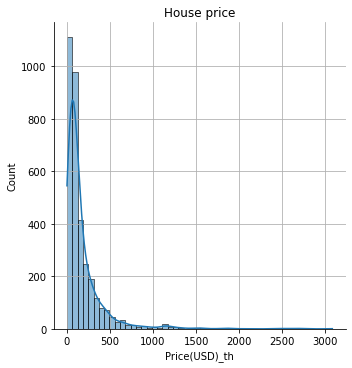

In [11]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Price(USD)_th'],kde=True,bins = 50)
plt.grid()
plt.title('House price')

In [12]:
df = df[(df['Price(USD)']<df['Price(USD)'].quantile(0.95)) & (df['Price(USD)']>df['Price(USD)'].quantile(0.05))]

Для удобства просмотра информации цена отображается в тысячах долларов. 
На гистограмме наблюдается длинный хвост в области низких цен. Для дальнейшего исследования отброшены по 5% самых дешевых и дорогих вариантов недвижимости, чтобы избежать краевых аномалий.

Text(0.5, 1.0, 'House price+')

<Figure size 700x400 with 0 Axes>

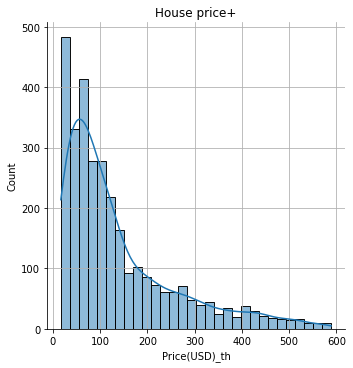

In [13]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Price(USD)_th'],kde=True,bins = 30)
plt.grid()
plt.title('House price+')

Text(0.5, 1.0, 'House area')

<Figure size 700x400 with 0 Axes>

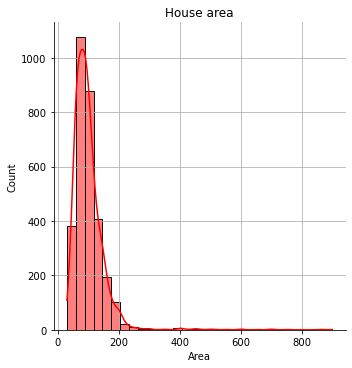

In [14]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Area'],kde=True,bins = 30, color = 'r')
plt.grid()
plt.title('House area')

In [15]:
df = df[~((df['Area']>60) & (df['Room']<1))]

Из рассмотрения также удалены квартиры с количеством жилых комнат равным 0 при площади квартиры более 60 квадратных метров, так как данные объекты могут вносить дисбаланс при обучении модели.

In [16]:
df["Address"] = df["Address"].astype('category')
df_1 = pd.DataFrame(df.groupby('Address')['Price(USD)_th'].agg('median').sort_values())
df_1['C'] = np.arange(len(df_1))
df["Address"] = df["Address"].map(df_1['C'].to_dict())
df["Address"] = df["Address"].astype('int')
df["Address"]

0        99
1        99
2         7
3        21
4       173
       ... 
3472     65
3473     97
3474    106
3475    177
3477    174
Name: Address, Length: 3104, dtype: int32

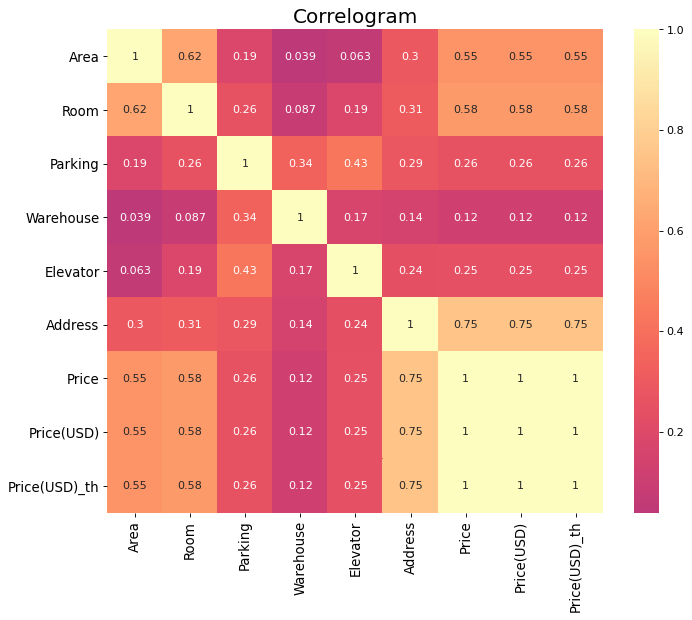

In [17]:
plt.figure(figsize=(10,8), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='magma', center=0, annot=True)
plt.title('Correlogram', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Данный график демонстрирует корреляцию между признаками и целевым признаком. Основная взаимосвязь стоимости наблюдается с площадью жилья и количеством комнат.
Корреляция района и стоимости наблюдается, так как при кодировании данного признака производилась сортировка по медианной стоимости жилья в каждом районе.

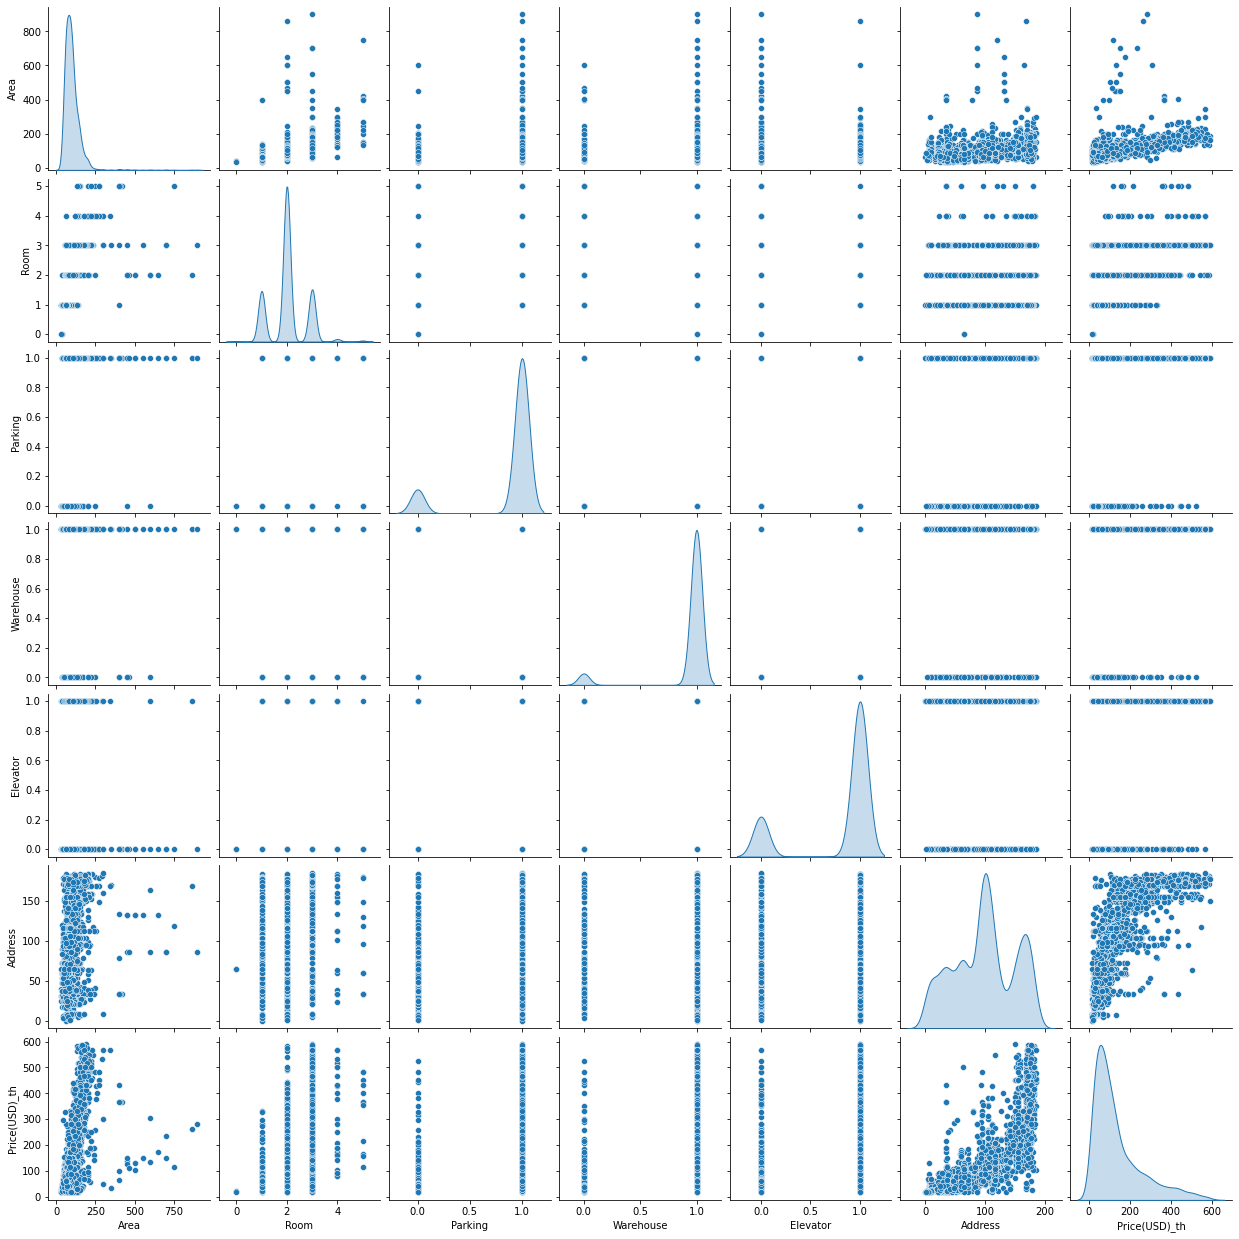

In [18]:
sns.pairplot(df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address',  'Price(USD)_th']], diag_kind='kde')

In [19]:
df[['Parking_str','Warehouse_str','Elevator_str']] =df[['Parking','Warehouse','Elevator']] .astype(str)
df[['Parking','Warehouse','Elevator']] = df[['Parking','Warehouse','Elevator']]*1

Text(0.5, 1.0, 'House price')

<Figure size 800x400 with 0 Axes>

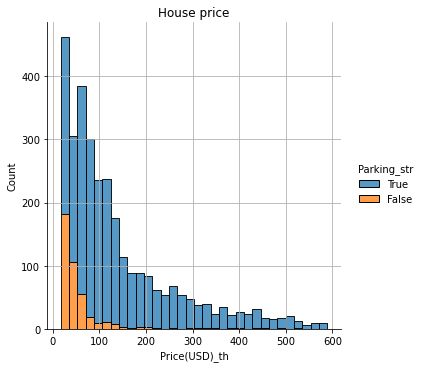

In [20]:
plt.figure(figsize=(8,4), dpi=100)
sns.displot(data=df, x="Price(USD)_th", hue="Parking_str", multiple="stack")
plt.grid()
plt.title('House price')

Text(0.5, 1.0, 'House price')

<Figure size 576x360 with 0 Axes>

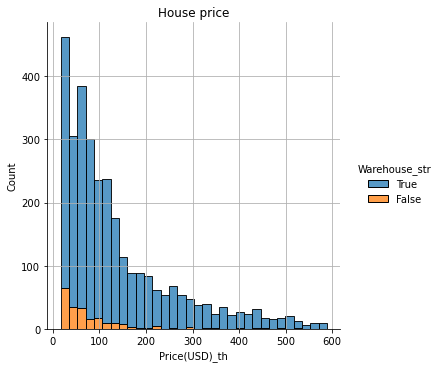

In [21]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x="Price(USD)_th", hue="Warehouse_str", multiple="stack")
plt.grid()
plt.title('House price')

Text(0.5, 1.0, 'House price')

<Figure size 576x360 with 0 Axes>

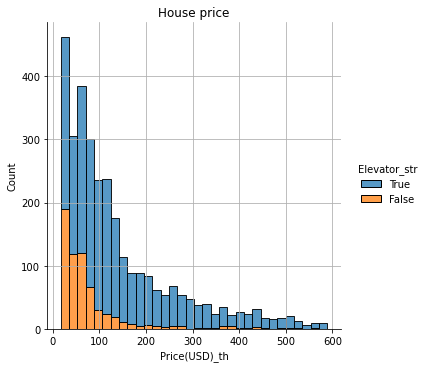

In [22]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x="Price(USD)_th", hue="Elevator_str", multiple="stack")
plt.grid()
plt.title('House price')

Основная масса представленных вариантов жилой недвижимости имеет в  дополнении паркинг, складское помещение и лифт. Распределения по стоимости о всех видов жилья похожи.

## Подготовка данных для обучения моделей

In [23]:
numeric_cols = [name for name in df.columns if df[name].dtype in ['int64', 'int32','float']]
print(numeric_cols)

['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)', 'Price(USD)_th']


In [24]:
X = df[numeric_cols].drop(['Price', 'Price(USD)', 'Price(USD)_th'], axis=1)
y = df['Price(USD)_th']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                                random_state=123456)

In [26]:
X_train.shape

(2483, 6)

In [27]:
X_test.shape

(621, 6)

In [28]:
def scal(data_1, data_2):
    """Масштабирование данных"""
    scaler = StandardScaler()
    scaler.fit(data_1)
    data_1 = scaler.transform(data_1)
    data_2 = scaler.transform(data_2)
    return data_1, data_2

In [29]:
def rmse(target, pred):
    """Создание метрики для применения ее в GridSearchCV """
    return (mean_squared_error(target, pred)**0.5)
my_score = make_scorer(rmse, greater_is_better=False)

In [30]:
def models(features, target, model_name, parameter):
    '''Подбор гиперпараметров'''
    start_time = datetime.now()
    model = GridSearchCV(model_name, parameter, refit=True, scoring = my_score, cv=5)
    best_model = model.fit(features,target)
    prediction = best_model.predict(features)
    end_time = datetime.now()
    time = end_time - start_time
    print(best_model.best_params_)
    print(best_model.best_score_)
    return best_model, prediction, best_model.best_params_, time

In [31]:
def predict_data(model,features_test, target_test):
    """Предсказание и измерение времени """
    start_time = datetime.now()
    pred_test = model.predict(features_test)
    end_time = datetime.now()
    time_predict = end_time - start_time
    rmse_test = rmse(target_test,pred_test)
    print('RMSE_test:',round(rmse_test,2))
    print('MAE_test:',round(mean_absolute_error(target_test,pred_test),2))
    print('R2_test:',round(r2_score(target_test,pred_test),2))
    print('time_predict:',time_predict)
    return rmse_test, time_predict, pred_test

Данные разбиты на обучающую и тестовую выборки. В дальнейшем подбор гиперпараметров и обучении моделей будет происходить с применением кросс-валидации. Также подготовлены функции.

## Обучение моделей

In [32]:
X_train_s, X_test_s = scal(X_train, X_test)

In [33]:

sgd = SGDRegressor()
params_sgd = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling']
}

In [34]:
%%time
best_model_sgd, prediction_sgd, params_sgd, time_sgd = models(X_train_s, y_train, sgd, params_sgd)

{'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l2'}
-63.00445970729701
Wall time: 14.6 s


In [35]:
rmse_test_s, time_predict_s, pred_test_sgd = predict_data(best_model_sgd, X_test_s, y_test)

RMSE_test: 65.62
MAE_test: 46.49
R2_test: 0.73
time_predict: 0:00:00


Результаты метрик RMSE(66 000) и  MAE(47000) для стохастического градиентного спуска достаточно велики, учитывая тот факт, что медианное значение цены - около 100 000 долларов. R2 равное 0,73, говорит о том, что взаимосвязь между признаками есть неплохая.

In [36]:
cbr = CatBoostRegressor()
params_cbr = {'depth': [7, 10, 20],
          'learning_rate' : [0.3, 1],
          'iterations': [2000],
             'verbose': [500]}

In [37]:
%%time
best_model_cbr, prediction_cbr, params_cbr, time_cbr = models(X_train_s, y_train, cbr, params_cbr)

0:	learn: 91.9736545	total: 77ms	remaining: 2m 33s
500:	learn: 18.0351909	total: 2.12s	remaining: 6.35s
1000:	learn: 15.4389924	total: 4.18s	remaining: 4.17s
1500:	learn: 14.5223677	total: 5.92s	remaining: 1.97s
1999:	learn: 14.1216158	total: 7.81s	remaining: 0us
0:	learn: 93.0383342	total: 5.07ms	remaining: 10.1s
500:	learn: 17.2380258	total: 2.25s	remaining: 6.75s
1000:	learn: 14.9646997	total: 4.54s	remaining: 4.53s
1500:	learn: 14.0577384	total: 6.68s	remaining: 2.22s
1999:	learn: 13.6215929	total: 8.92s	remaining: 0us
0:	learn: 90.8430614	total: 3.87ms	remaining: 7.74s
500:	learn: 16.7427349	total: 1.91s	remaining: 5.7s
1000:	learn: 13.6436036	total: 3.67s	remaining: 3.66s
1500:	learn: 12.4080840	total: 6s	remaining: 2s
1999:	learn: 11.8147124	total: 8.26s	remaining: 0us
0:	learn: 93.2119281	total: 5.04ms	remaining: 10.1s
500:	learn: 19.3303032	total: 2.17s	remaining: 6.51s
1000:	learn: 16.5508496	total: 4.68s	remaining: 4.67s
1500:	learn: 15.5263587	total: 6.69s	remaining: 2.23s


In [38]:
rmse_test_cbr, time_predict_cbr,pred_test_cbr = predict_data(best_model_cbr, X_test_s, y_test)

RMSE_test: 52.69
MAE_test: 28.42
R2_test: 0.83
time_predict: 0:00:00.101154


Результаты метрик RMSE(53 000) и MAE(29 000) для модели градиентного бустинга достаточно лучше чем для предыдущей модели. R2 составило 0,83.
Для указанной модели ниже будет продемонстрирована разница рельных значений целевого признака и предсказанных.

Text(0.5, 1.0, 'Difference between true value and predicted')

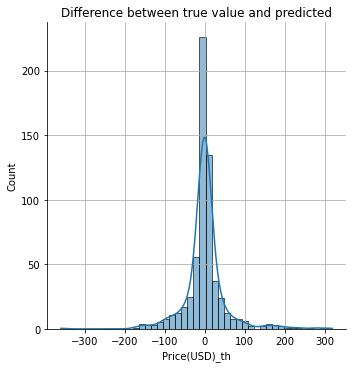

In [39]:
yy = y_test - pred_test_cbr
sns.displot(yy, bins=45,kde=True)
plt.grid()
plt.title('Difference between true value and predicted')

Text(0.5, 1.0, 'Difference between true value and predicted')

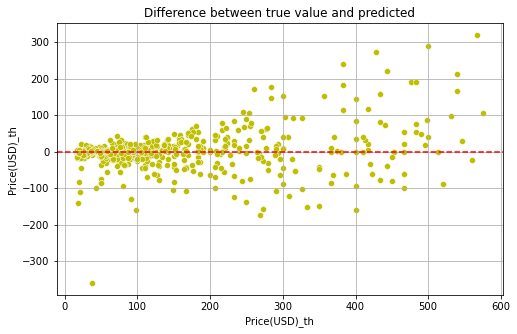

In [40]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test,y=yy, color = 'y')
plt.axhline(y=0,color='r',ls='--')
plt.grid()
plt.title('Difference between true value and predicted')

In [41]:
res_all = np.array([['SGDRegressor', round(rmse_test_s,2)],['CatBoostRegressor', round(rmse_test_cbr,2)]])
result_all = pd.DataFrame(res_all,columns = ['Name','RMSE'])

In [42]:
result_all

,Name,RMSE
0,SGDRegressor,65.62
1,CatBoostRegressor,52.69


# Выводы
В результате исследования данных были выявлены отсутствующие и аномальные значения, преобразованы типы данных и подготовлены для обучения моделей. 
Основное влияние на стоимость жилой недвижимости из представленных данных оказывает количество комнат и площадь. 
Были рассмотрены 2 модели: стохастический градиентный спуск и градиентный бустинг. Обе модели показали не лучший результат, так как метрика RMSE составила более 50 000 долларов при медианной цене около100000. Но все-таки лучшие показатели оказались у градиентного бустинга. Его и рекомендуется использовать в дальнейшем для предсказания цены.
